In [1]:
import pandas as pd
# import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from mlxtend.evaluate import bias_variance_decomp

In [4]:
# bids_df= pd.read_csv('data/bids.csv')
# train_df = pd.read_csv('data/train.csv')
# test_df= pd.read_csv('data/test.csv')

In [8]:
train_set = pd.read_csv("./new_train.csv")
test_set = pd.read_csv("./new_test.csv")

In [ ]:
bids_unique= bids_df.groupby('bidder_id').nunique()
bids_unique = bids_unique.drop(["bid_id"],axis = 1)

In [ ]:
train_set = train_df.merge(bids_unique, how= 'left', on = 'bidder_id')
test_set = test_df.merge(bids_unique, how= 'left', on = 'bidder_id')

In [9]:
print("TRAIN SET")
print(train_set.isnull().sum())
print("-" * 100)
print("TEST SET")
print(test_set.isnull().sum())

TRAIN SET
Unnamed: 0                                   0
bidder_id                                    0
payment_account                              0
address                                      0
outcome                                      0
auction                                      0
merchandise                                  0
device                                       0
time                                         0
country                                      0
ip                                           0
url                                          0
num_bids                                     0
num_first_bids                               0
num_last_bids                                0
time_to_bid                                  0
inst_resp                                    0
perc_inst_resp                               0
auto parts                                   0
books and music                              0
clothing                                     0
com

In [10]:
train_set.fillna(0,inplace = True)
test_set.fillna(0,inplace = True)

In [13]:
print("TRAIN SET")
print(train_set.isnull().sum())
print("-" * 100)
print("TEST SET")
print(test_set.isnull().sum())

TRAIN SET
bidder_id          0
payment_account    0
address            0
outcome            0
auction            0
merchandise        0
device             0
time               0
country            0
ip                 0
url                0
dtype: int64
----------------------------------------------------------------------------------------------------
TEST SET
bidder_id          0
payment_account    0
address            0
auction            0
merchandise        0
device             0
time               0
country            0
ip                 0
url                0
dtype: int64


In [41]:
X = train_set.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome']) 
y = train_set['outcome']
X_test_original = test_set.drop(columns=['bidder_id', 'payment_account', 'address'])

In [42]:
def evaluate(model, X_train, y_train, X_test, y_test):
    print("TRAIN")
    train_predictions = model.predict_proba(X_train)
    train_pred = model.predict(X_train)
        
    train_accuracy = accuracy_score(y_train, train_pred)
    train_auc_roc_score = roc_auc_score(y_train,train_predictions[:,1])
    train_fbeta = fbeta_score(y_train, train_pred, average='binary', beta=2.0)
    
    print("Classification report")
    print(classification_report(y_train, train_pred, digits = 4))
    
    print("FBeta Score")
    print(fbeta_score(y_train, train_pred, average='binary', beta=2.0))
    
    print('Model Performance')
    print('Accuracy = {:0.4f}%.'.format(train_accuracy))
    print('AUC ROC = {:0.4f}%.'.format(train_auc_roc_score))
    print("*" * 100)
    
    print("TEST")
    
    test_predictions = model.predict_proba(X_test)
    test_pred = model.predict(X_test)
        
    test_accuracy = accuracy_score(y_test, test_pred)
    test_auc_roc_score = roc_auc_score(y_test,test_predictions[:,1])
    test_fbeta = fbeta_score(y_test, test_pred, average='binary', beta=2.0)
    
    print("Classification report")
    print(classification_report(y_test, test_pred, digits = 4))
    
    print("FBeta Score")
    print(fbeta_score(y_test, test_pred, average='binary', beta=2.0))
    
    print('Model Performance')
    print('Accuracy = {:0.4f}%.'.format(test_accuracy))
    print('AUC ROC = {:0.4f}%.'.format(test_auc_roc_score))
    print("*" * 100)
    
    return [train_accuracy, train_auc_roc_score, train_fbeta, test_accuracy, test_auc_roc_score, test_fbeta]

def process_results(arr):
    train_accuracy = []
    train_auc_roc_score = [] 
    train_fbeta = []
    test_accuracy = []
    test_auc_roc_score = []
    test_fbeta = []
    
    for item in arr:
        train_accuracy.append(item[0])
        train_auc_roc_score.append(item[1])
        train_fbeta.append(item[2])
        test_accuracy.append(item[3])
        test_auc_roc_score.append(item[4])
        test_fbeta.append(item[5])
    
    mean_accuracy = np.array(train_accuracy).mean()
    mean_train_auc_roc_score = np.array(train_auc_roc_score).mean()
    mean_train_fbeta = np.array(train_fbeta).mean()
    mean_test_accuracy = np.array(test_accuracy).mean()
    mean_test_auc_roc_score = np.array(test_auc_roc_score).mean()
    mean_test_fbeta = np.array(test_fbeta).mean()
    
    print("final train accuracy: " + str(mean_accuracy))
    print("final train AUC: " + str(mean_train_auc_roc_score))
    print("final train fbeta: " + str(mean_train_fbeta))
    print("final test accuracy: " + str(mean_test_accuracy))
    print("final test AUC: " + str(mean_test_auc_roc_score))
    print("final test fbeta: " + str(mean_test_fbeta))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
def create_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
# ann = KerasClassifier(build_fn=create_model, verbose=0)

In [17]:
dt.fit(X_train, y_train)
evaluate(dt, X_train, y_train, X_test, y_test)

TRAIN
Classification report
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000      1333
         1.0     1.0000    1.0000    1.0000        76

    accuracy                         1.0000      1409
   macro avg     1.0000    1.0000    1.0000      1409
weighted avg     1.0000    1.0000    1.0000      1409

FBeta Score
1.0
Model Performance
Accuracy = 1.0000%.
AUC ROC = 1.0000%.
****************************************************************************************************
TEST
Classification report
              precision    recall  f1-score   support

         0.0     0.9759    0.9827    0.9793       577
         1.0     0.5652    0.4815    0.5200        27

    accuracy                         0.9603       604
   macro avg     0.7706    0.7321    0.7496       604
weighted avg     0.9575    0.9603    0.9587       604

FBeta Score
0.4961832061068702
Model Performance
Accuracy = 0.9603%.
AUC ROC = 0.7321%.
*****************************

[1.0, 1.0, 1.0, 0.9602649006622517, 0.732075229475576, 0.4961832061068702]

In [18]:
rf.fit(X_train, y_train)
evaluate(rf, X_train, y_train, X_test, y_test)

TRAIN
Classification report
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000      1333
         1.0     1.0000    1.0000    1.0000        76

    accuracy                         1.0000      1409
   macro avg     1.0000    1.0000    1.0000      1409
weighted avg     1.0000    1.0000    1.0000      1409

FBeta Score
1.0
Model Performance
Accuracy = 1.0000%.
AUC ROC = 1.0000%.
****************************************************************************************************
TEST
Classification report
              precision    recall  f1-score   support

         0.0     0.9680    0.9965    0.9821       577
         1.0     0.8000    0.2963    0.4324        27

    accuracy                         0.9652       604
   macro avg     0.8840    0.6464    0.7072       604
weighted avg     0.9605    0.9652    0.9575       604

FBeta Score
0.3389830508474576
Model Performance
Accuracy = 0.9652%.
AUC ROC = 0.9077%.
*****************************

[1.0, 1.0, 1.0, 0.9652317880794702, 0.9076641632967456, 0.3389830508474576]

In [19]:
xgb.fit(X_train, y_train)
evaluate(xgb, X_train, y_train, X_test, y_test)

[21:35:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1635105055642/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN
Classification report
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000      1333
         1.0     1.0000    1.0000    1.0000        76

    accuracy                         1.0000      1409
   macro avg     1.0000    1.0000    1.0000      1409
weighted avg     1.0000    1.0000    1.0000      1409

FBeta Score
1.0
Model Performance
Accuracy = 1.0000%.
AUC ROC = 1.0000%.
****************************************************************************************************
TEST
Classification report
              precision    recall  f1-score   support

         0.0     0.9694    0.9896    0.9794       577
         1.0     0

/opt/homebrew/Caskroom/miniforge/base/envs/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1.0, 1.0, 1.0, 0.9602649006622517, 0.8927402272289621, 0.36585365853658536]

In [20]:
ann.fit(X_train, y_train)
evaluate(ann, X_train, y_train, X_test, y_test)

NameError: name 'ann' is not defined

In [21]:
X_train.shape

(1409, 54)

In [22]:
# train_sizes=np.linspace(0.1, 1.0, 5)

# train_sizes, train_scores, validation_scores = learning_curve(
# estimator = dt,
# X = X,
# y = y, train_sizes = train_sizes, cv = 5)

In [23]:
# print("Training scores:\n\n", train_scores)

In [24]:
# print('\nValidation scores:\n\n', validation_scores)

In [25]:
# train_scores_mean = train_scores.mean(axis = 1)

In [26]:
# validation_scores_mean = validation_scores.mean(axis = 1)

In [27]:
# print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
# print('\n', '-' * 20)
# print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

In [28]:
# import matplotlib.pyplot as plt
# plt.style.use('seaborn')
# plt.plot(train_sizes, train_scores_mean, label = 'Training error')
# plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
# plt.ylabel('Accuracy', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves for a Decision Tree model', fontsize = 18, y = 1.03)
# plt.legend()

In [29]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    return plt

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(10, 15))

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = DecisionTreeClassifier(random_state = 42)
plot_learning_curve(
    estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(random_state = 42)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()


NameError: name 'plt' is not defined

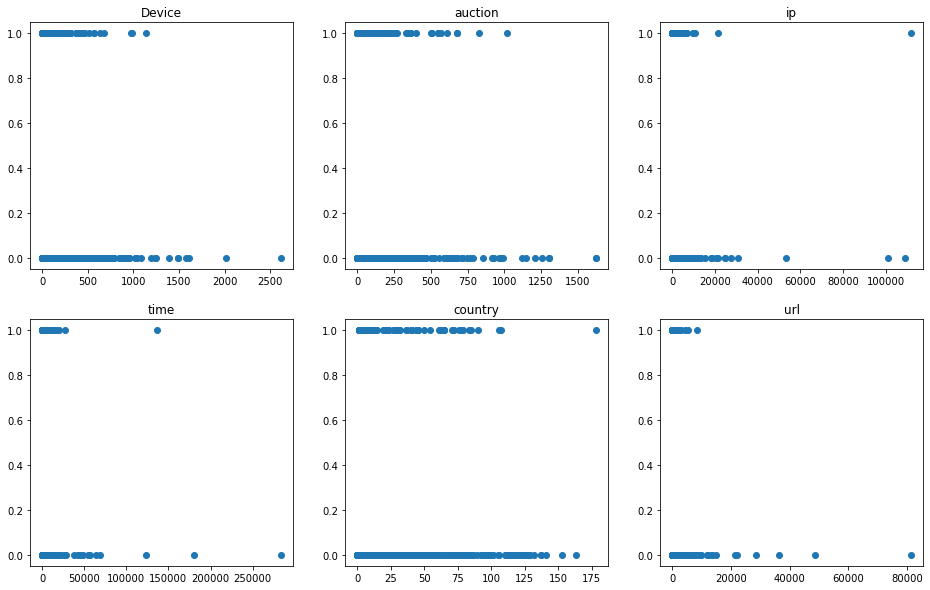

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3, figsize=(16,10))
ax[0,0].scatter(train_set['device'], train_set['outcome'])
ax[0,0].title.set_text('Device')
ax[0,1].scatter(train_set['auction'], train_set['outcome'])
ax[0,1].title.set_text('auction')
ax[1,0].scatter(train_set['time'], train_set['outcome'])
ax[1,0].title.set_text('time')
ax[1,1].scatter(train_set['country'], train_set['outcome'])
ax[1,1].title.set_text('country')
ax[0,2].scatter(train_set['ip'], train_set['outcome'])
ax[0,2].title.set_text('ip')
ax[1,2].scatter(train_set['url'], train_set['outcome'])
ax[1,2].title.set_text('url')

IndexError: index 3 is out of bounds for axis 1 with size 3

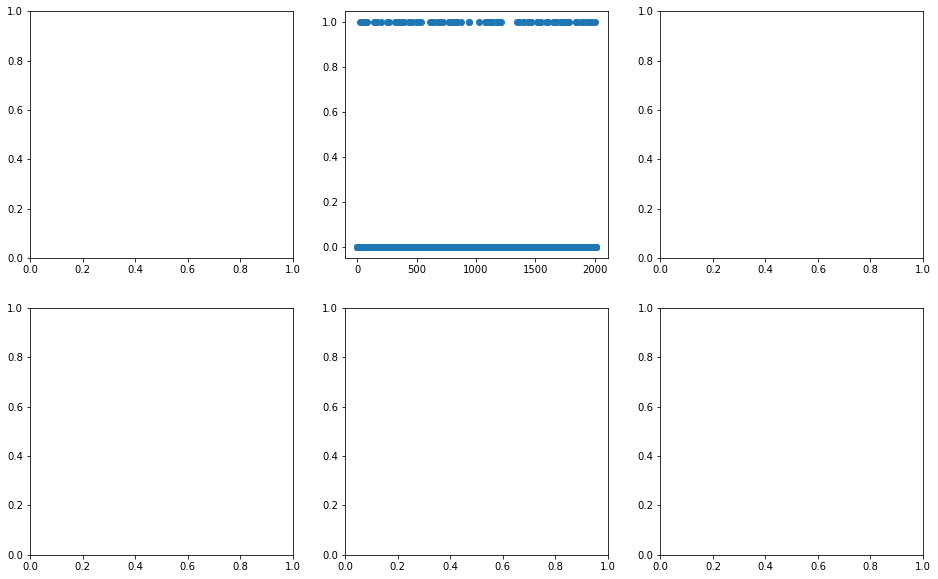

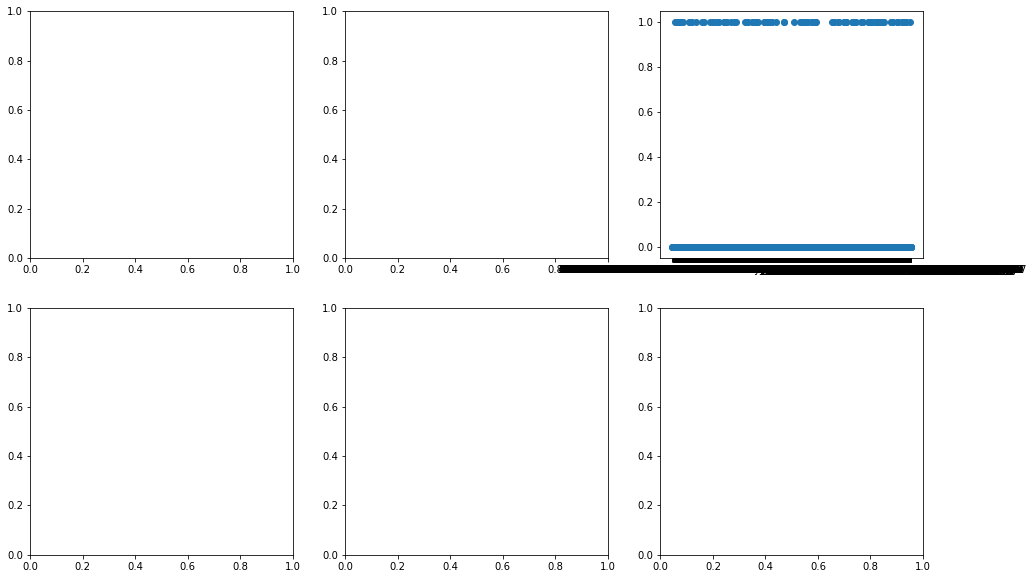

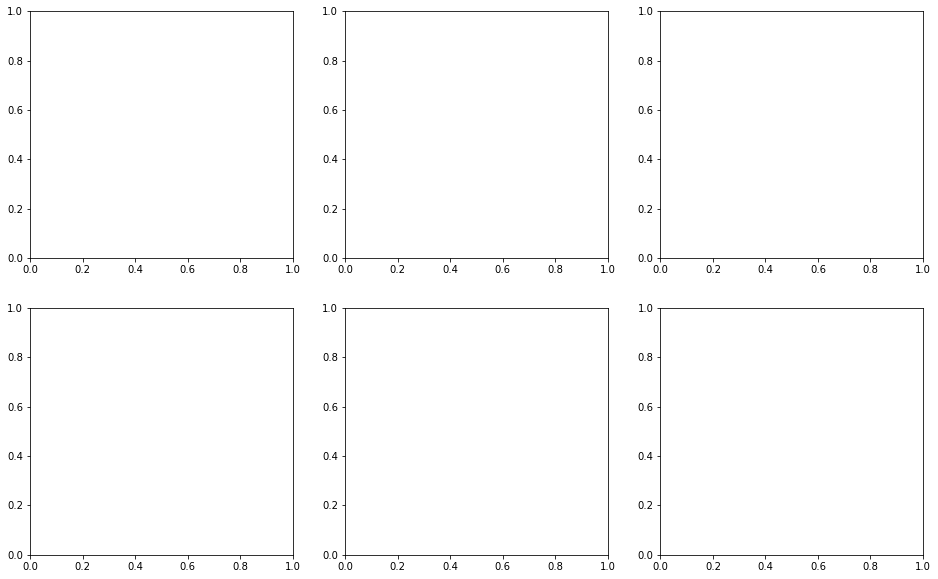

In [39]:
import matplotlib.pyplot as plt
count = 0
first_col = 0
eachItem = train_set.columns
for item in eachItem:
    count+=1
    if(count% 3 == 0):
        first_col +=1
    fig, ax = plt.subplots(2,3, figsize=(16,10))

    ax[first_col,count].scatter(train_set[item], train_set['outcome'])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
tree = DecisionTreeClassifier(random_state=42)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=42)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

ValueError: The bias_variance_decomp does not support pandas DataFrames yet. Please check the inputs to X_train, y_train, X_test, y_test. If e.g., X_train is a pandas DataFrame, try passing it as NumPy array via X_train=X_train.values.

In [45]:
from mlxtend.evaluate import bias_variance_decomp
from sklearn.tree import DecisionTreeClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split


tree = DecisionTreeClassifier(random_state=123)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        tree, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=123)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

ValueError: The bias_variance_decomp does not support pandas DataFrames yet. Please check the inputs to X_train, y_train, X_test, y_test. If e.g., X_train is a pandas DataFrame, try passing it as NumPy array via X_train=X_train.values.